Initialisation of V^*...


Running experiments:   0%|          | 0/30 [00:00<?, ?it/s]

Running MBIE instance for replicate 0:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 1:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 2:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 3:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 4:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 5:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 6:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 7:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 8:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 9:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 10:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 11:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 12:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 13:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 14:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 15:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 16:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 17:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 18:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 19:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 20:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 21:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 22:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 23:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 24:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 25:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 26:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 27:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 28:   0%|          | 0/29999 [00:00<?, ?it/s]

Running MBIE instance for replicate 29:   0%|          | 0/29999 [00:00<?, ?it/s]

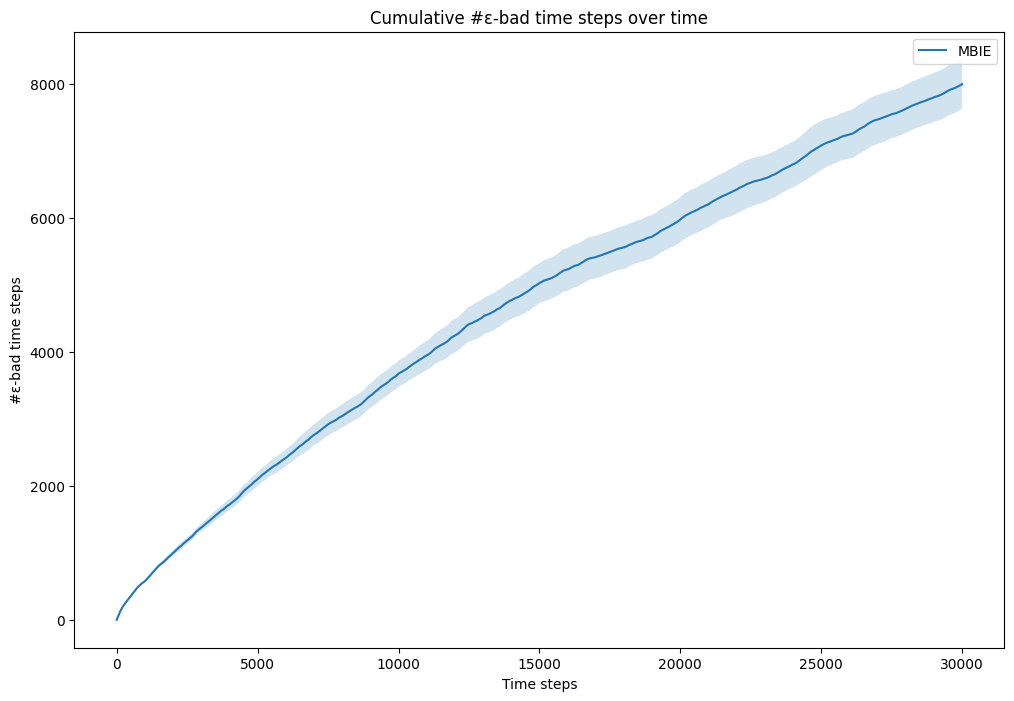

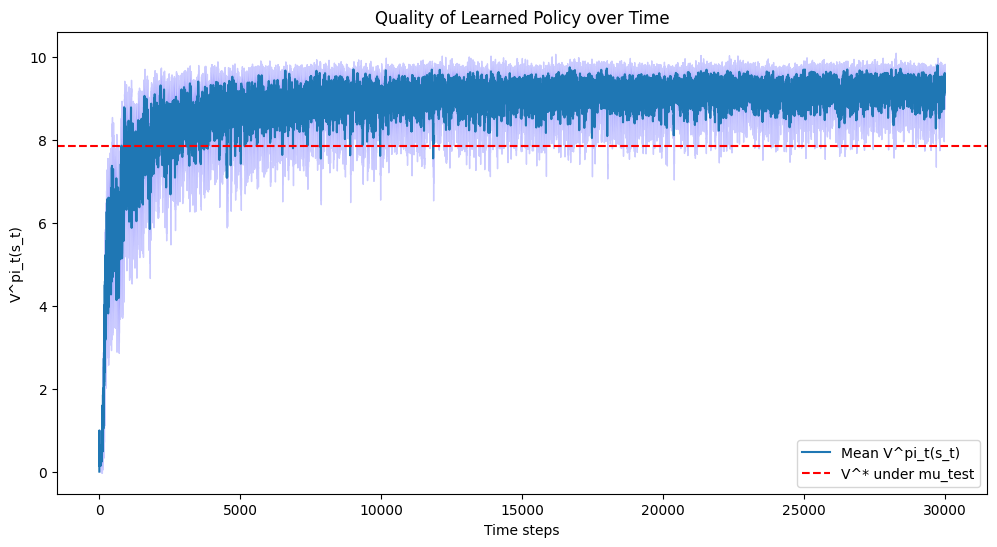

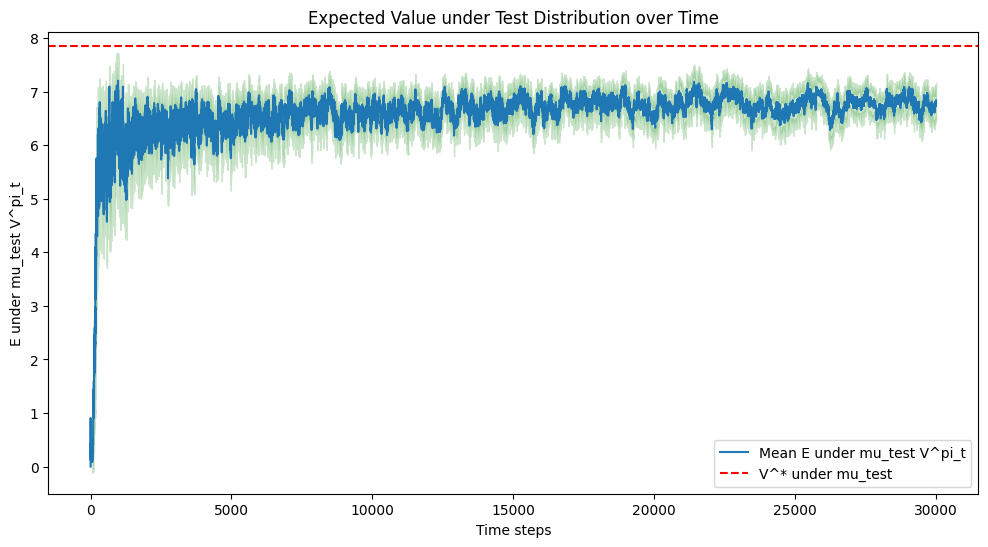

In [11]:
from riverswim import MBIE, make_V_list, map_pi, riverswim
import numpy as np
import copy as cp
import pylab as pl
from tqdm.notebook import tqdm


nS = 5
env = riverswim(nS)
gamma = 0.95
epsilon = 0.1
delta = 0.05

# Set the time horizon:
T = 3 * 10**4
nb_Replicates = 30

# Set the learning agents:
MB = MBIE(nS, 2, gamma, epsilon, delta)

# Set the variables used for plotting.
cumerror_MB = np.zeros((nb_Replicates, T))

print("Initialisation of V^*...")
V, V_star = make_V_list(env, gamma)

# Calculate V* under the test distribution
uniform_dist = np.ones(nS) / nS
V_star_under_mu_test = np.dot(V_star, uniform_dist)

# For storing V_pi(s_t) and the expected V under mu_test
V_pi_values = np.zeros((nb_Replicates, T))
E_V_mu_test_values = np.zeros((nb_Replicates, T))

# Run the experiments:
for i in tqdm(range(nb_Replicates), desc="Running experiments"):
    # Running an instance of MBIE:
    initial_state = env.reset()
    MB.reset(initial_state)
    
    reward = 0
    state = initial_state
    
    for t in tqdm(range(1, T), desc=f"Running MBIE instance for replicate {i}"):
        # Take action using MBIE policy
        action, policy = MB.play(state, reward)
        
        # (ii) Evaluate and store V^pi_t(s_t) at each time step
        V_pi = V[map_pi(policy)]
        V_pi_values[i, t] = V_pi[state]
        
        # (iii) Evaluate and store E under mu_test for V^pi_t
        E_V_mu_test_values[i, t] = np.dot(V_pi, uniform_dist)
        
        # Increment ε-bad counter if the value is less than V* - ε at the current state
        cumerror_MB[i, t] = cumerror_MB[i, t-1] + (int(V_pi[state] < V_star[state] - epsilon))
        
        # Transition to new state and get reward
        state, reward = env.step(action)


# Calculate mean and confidence intervals for (ii) V^pi_t(s_t)
mean_V_pi = np.mean(V_pi_values, axis=0)
std_V_pi = np.std(V_pi_values, axis=0)
confidence_interval_V_pi = 1.96 * std_V_pi / np.sqrt(nb_Replicates)

# Calculate mean and confidence intervals for (iii) E under mu_test for V^pi_t
mean_E_V_mu_test = np.mean(E_V_mu_test_values, axis=0)
std_E_V_mu_test = np.std(E_V_mu_test_values, axis=0)
confidence_interval_E_V_mu_test = 1.96 * std_E_V_mu_test / np.sqrt(nb_Replicates)

mean_error = cumerror_MB.mean(axis=0)
std_error = cumerror_MB.std(axis=0) / np.sqrt(nb_Replicates)
time_steps = np.arange(T)

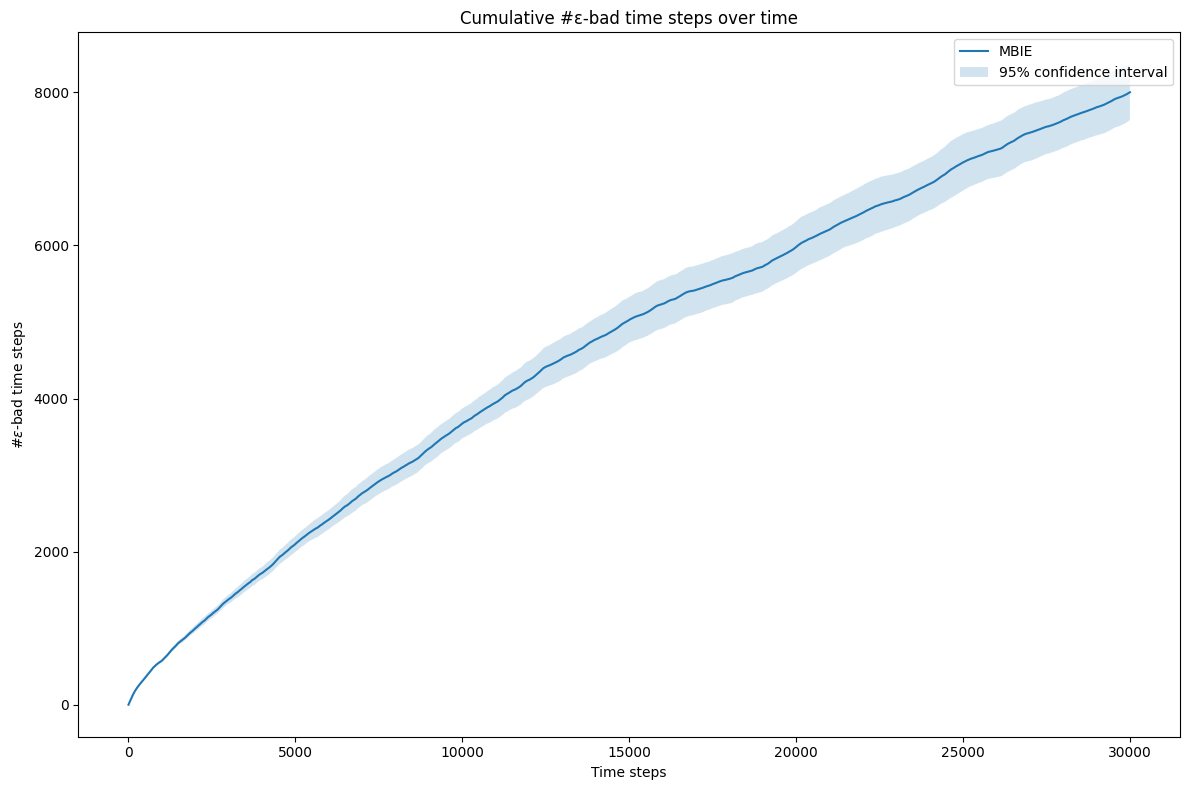

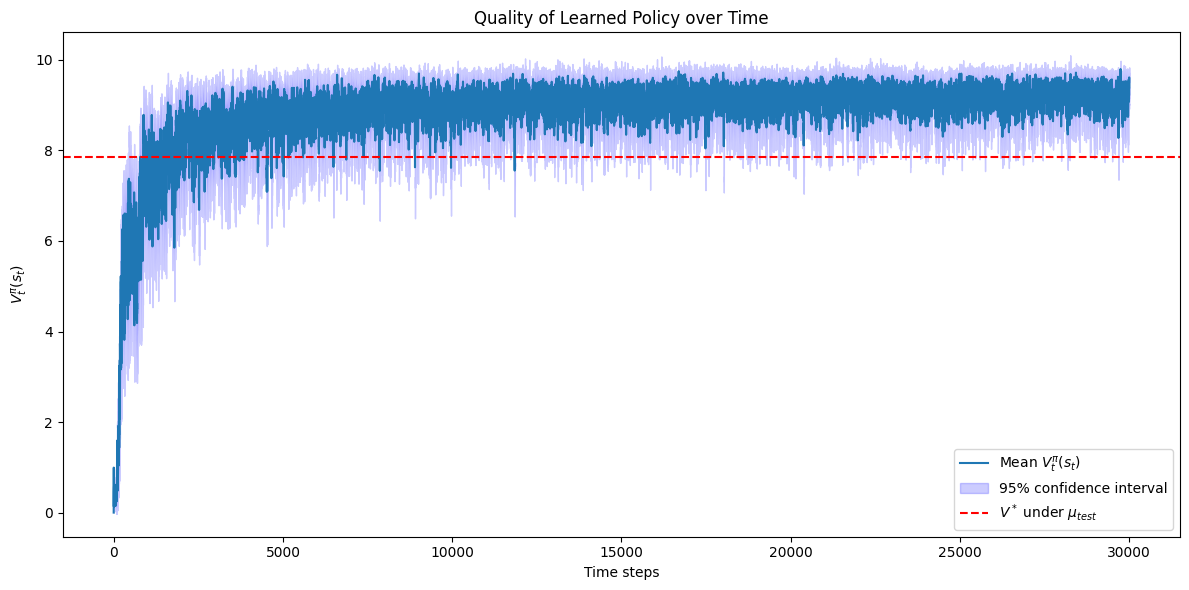

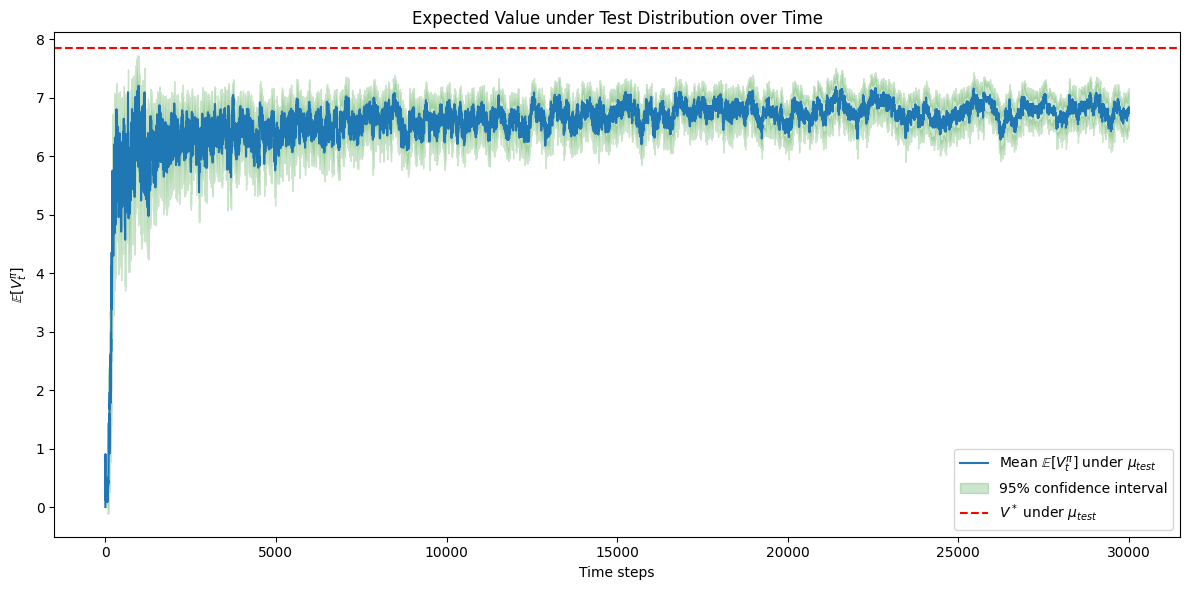

In [34]:
# Plotting for (i)
pl.figure(figsize=(12, 8))
# Plot mean with 95% confidence intervals
pl.plot(time_steps, mean_error, label='MBIE')
pl.fill_between(time_steps, mean_error - 1.96 * std_error, mean_error + 1.96 * std_error, alpha=0.2, label='95% confidence interval')

# Labels and title
pl.xlabel('Time steps')
pl.ylabel(r'#$\epsilon$-bad time steps')
pl.title('Cumulative #ε-bad time steps over time')
pl.tight_layout()
pl.legend()
pl.savefig('artifacts/mbie_performance.pdf')
pl.show()

# Plotting for (ii)
pl.figure(figsize=(12, 6))
pl.plot(time_steps, mean_V_pi, label=r'Mean $V^\pi_t(s_t)$')
pl.fill_between(time_steps, mean_V_pi - confidence_interval_V_pi, mean_V_pi + confidence_interval_V_pi, alpha=0.2, color='blue', label='95% confidence interval')
# Plot V* as a horizontal line (using latex)
pl.axhline(y=V_star_under_mu_test, color='r', linestyle='--', label=r'$V^*$ under $\mu_{test}$')
pl.xlabel('Time steps')
pl.ylabel(r'$V^\pi_t(s_t)$')
pl.title('Quality of Learned Policy over Time')
pl.tight_layout()
pl.legend()
pl.savefig('artifacts/mbie_quality.pdf')
pl.show()

# Plotting for (iii)
pl.figure(figsize=(12, 6))
pl.plot(time_steps, mean_E_V_mu_test, label=r'Mean $\mathbb{E}[V^\pi_t]$ under $\mu_{test}$')
pl.fill_between(time_steps, mean_E_V_mu_test - confidence_interval_E_V_mu_test, mean_E_V_mu_test + confidence_interval_E_V_mu_test, alpha=0.2, color='green', label=r'95% confidence interval')
# Plot V* as a horizontal line again for comparison
pl.axhline(y=V_star_under_mu_test, color='r', linestyle='--', label=r'$V^*$ under $\mu_{test}$')
pl.xlabel('Time steps')
pl.ylabel(r'$\mathbb{E}[V^\pi_t]$')
pl.title('Expected Value under Test Distribution over Time')
pl.tight_layout()
pl.legend()
pl.savefig('artifacts/mbie_expected_value.pdf')
pl.show()
